<a href="https://colab.research.google.com/github/arun-reddy-a/SRIP-Questions-2023/blob/main/SRIP_Questions_Arun_Reddy.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Question 1**

In [ ]:
import jax.numpy as jnp
from jax import random, jit
import matplotlib.pyplot as plt

In [ ]:
@jit
def pdf(x, a, b, c):
    return (a/b) * jnp.power((x-c)/b, -a-1) * jnp.exp(-jnp.power((x-c)/b, -a))

@jit
def kde(x, bw, x_grid):
    n = x.shape[0]
    h = bw*jnp.power(4/(3*n), 1/5)
    y = x.reshape(n, 1) - x_grid.reshape(1, x_grid.shape[0])
    y = y/h
    y = jnp.exp(-0.5*jnp.power(y, 2))
    y = jnp.mean(y, axis=1)
    y = y/(jnp.sqrt(2*jnp.pi)*h)
    return y

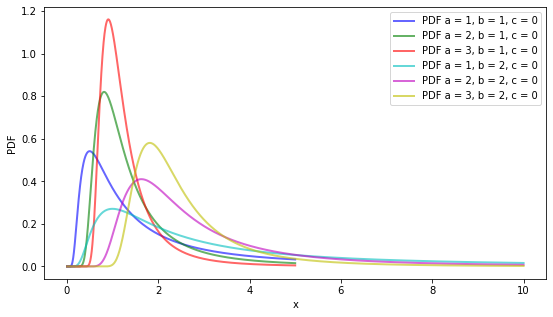

In [ ]:
def get_frechlet_pdf(a,b,c,color,ax):
    n_samples = 10000


    key = random.PRNGKey(0)
    u = random.uniform(key, shape=(n_samples,))
    x = c + jnp.power(-jnp.log(u), -1/a) / b



    x_grid = jnp.linspace(c, c+5*b, 1000)
    pdf_values = pdf(x_grid, a, b, c)
    kde_values = kde(x, 0.1, x_grid)
    ax.plot(x_grid, pdf_values, color, lw=2, alpha=0.6, label= f"PDF a = {a}, b = {b}, c = {c}")
    ax.set_xlabel('x')
    ax.set_ylabel('PDF')


fig,ax = plt.subplots(figsize = (9,5))
get_frechlet_pdf(1,1,0,'b-',ax)
get_frechlet_pdf(2,1,0,'g-', ax)
get_frechlet_pdf(3,1,0,'r-',ax)
get_frechlet_pdf(1,2,0,'c-',ax)
get_frechlet_pdf(2,2,0,'m-',ax)
get_frechlet_pdf(3,2,0,'y-',ax)
plt.legend(loc = 'best')
plt.show()


**Question 2**

In [ ]:
import numpy as np

def cross_entropy(p, q):
    
    ce = -jnp.sum(p * jnp.log(q))
    return ce

def entropy(p):
    
    ent = -jnp.sum(p * jnp.log(p))
    return ent

def mutual_information(p_joint, p_x, p_y):
    pxy = p_joint
    px = p_x
    py = p_y
    mi = 0
    for i in range(len(px)):
        for j in range(len(py)):
            if pxy[i,j] > 0:
                mi += pxy[i,j] * np.log(pxy[i,j] / (px[i] * py[j]))
    return mi



def conditional_entropy(p_joint, p_y):
    # Calculate the conditional probability distribution of X given Y
    p_x_given_y = p_joint / p_y[:, np.newaxis]
    # Replace any NaNs or Infs with zeros
    p_x_given_y[np.isnan(p_x_given_y) | np.isinf(p_x_given_y)] = 0
    # Add a small positive constant to any zero values in the conditional probability distribution
    p_x_given_y[p_x_given_y == 0] = np.finfo(float).eps
    # Calculate the conditional entropy of X given Y
    h_x_given_y = -np.sum(p_x_given_y * np.log2(p_x_given_y), axis=1)
    # Calculate the overall conditional entropy of X given Y
    h_x_cond_y = np.sum(p_y * h_x_given_y)
    return h_x_cond_y


def kl_divergence(p, q):
   
    

    # Calculate the KL divergence
    kl_div = np.sum(p * np.log2(p / q))
    
    return kl_div


**Question 3**

In [ ]:
import requests
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF, WhiteKernel, ConstantKernel as C, Matern, RationalQuadratic as RQ, ExpSineSquared as Exp, DotProduct as Lin
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestRegressor

In [ ]:
url = "https://api.openaq.org/v2/measurements"


params = {
    "location_id": "8118",
    "parameter": "pm25",
    "date_from": "2023-02-17T00:00:00Z",
    "date_to": "2023-02-24T00:00:00Z",
    "limit": 100000,
}


response = requests.get(url, params=params)
data = pd.DataFrame(response.json()["results"])
data.to_csv("openaq_data.csv", index=False)

data = data.drop(["locationId", "location", "parameter", "unit", "coordinates","country", "city", "isMobile", "isAnalysis", "entity", "sensorType"], axis = 1)
data = data.reindex(columns = ['date', 'value'])
X = np.array([data['date'][i]['local'] for i in range(len(data))])
data['date'] = X
X = np.array([data['date'][i][0:10]+" "+data['date'][i][11:-6] for i in range(len(data))])
data['date'] = X
data['date'] = pd.to_datetime(data['date'])

Y = np.array([data['date'][i].timestamp() for i in range(len(data))])
data_time_stamped = data.assign(date = Y)

data_time_stamped

,date,value
0,1.677215e+09,90.0
1,1.677211e+09,109.0
2,1.677208e+09,75.0
3,1.677204e+09,64.0
4,1.677200e+09,78.0
...,...,...
163,1.676628e+09,269.0
164,1.676624e+09,264.0
165,1.676621e+09,252.0
166,1.676617e+09,238.0


In [ ]:
data

,date,value
0,2023-02-24 05:00:00,90.0
1,2023-02-24 04:00:00,109.0
2,2023-02-24 03:00:00,75.0
3,2023-02-24 02:00:00,64.0
4,2023-02-24 01:00:00,78.0
...,...,...
163,2023-02-17 10:00:00,269.0
164,2023-02-17 09:00:00,264.0
165,2023-02-17 08:00:00,252.0
166,2023-02-17 07:00:00,238.0


interpolation

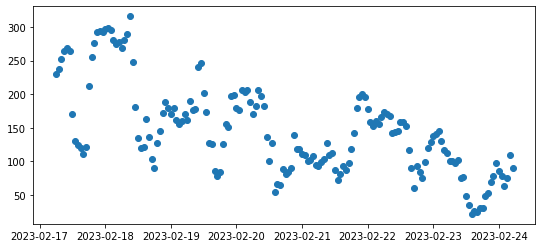

In [ ]:
plt.figure(figsize = (9,4))
plt.scatter(data['date'], data['value'])
plt.show()

RF Regressor

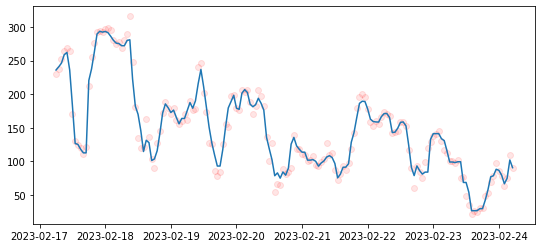

In [ ]:
X = data_time_stamped[['date']]
y = data_time_stamped['value']


X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
rf = RandomForestRegressor(n_estimators = 5)
rf.fit(X_train, y_train)
y_pred = rf.predict(X_test)
y_now = rf.predict(X)
X = np.array(X)
plt.figure(figsize = (9,4))
plt.plot(np.array(data['date']),y_now)
plt.scatter(data['date'], data['value'], c = 'r', alpha = 0.1)
plt.show()

Linear Regression

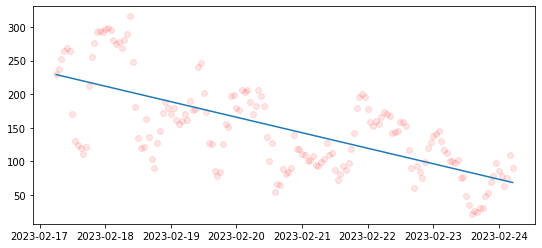

In [ ]:
X = data_time_stamped[['date']]
y = data_time_stamped['value']


X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
lin_r = LinearRegression()
lin_r.fit(X_train, y_train)
y_pred = lin_r.predict(X_test)
y_now = lin_r.predict(X)
X = np.array(X)
plt.figure(figsize = (9,4))
plt.plot(np.array(data['date']),y_now)
plt.scatter(data['date'], data['value'], c = 'r', alpha = 0.1)
plt.show()

Gaussian Process

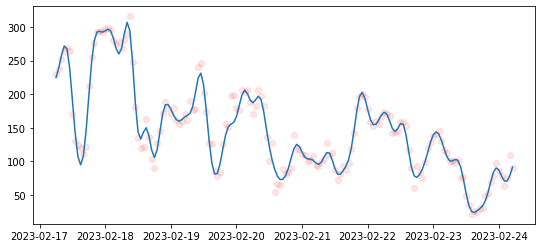

In [ ]:
X = data_time_stamped[['date']]
y = data_time_stamped['value']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state = 10)
gpr = GaussianProcessRegressor(alpha=0.0, kernel= WhiteKernel()+ 10*RBF(),n_restarts_optimizer=10, normalize_y=True, random_state = 42)

gpr.fit(X_train, y_train)
y_now = gpr.predict(X)
plt.figure(figsize = (9,4))
plt.plot(np.array(data['date']),y_now)
plt.scatter(data['date'], data['value'], c = 'r', alpha = 0.1)
plt.show()

K fold cross validation

In [ ]:
def k_fold_cv (X,y,model,n_splits):
    kf_indices = np.array_split(np.arange(len(X)), n_splits)
    mse_scores = []
    for i in range(n_splits):
        # Split data into train and test sets for this fold
        scaler = StandardScaler()
        test_indices = kf_indices[i]
        train_indices = np.concatenate(kf_indices[:i] + kf_indices[i+1:])
        X_train, y_train = X[train_indices], y[train_indices]
        X_test, y_test = X[test_indices], y[test_indices]
        X_train = scaler.fit_transform(X_train.reshape(-1,1))
        X_test = scaler.transform(X_test.reshape(-1,1))

        # Fit the model and predict on test data
        model.fit(X_train.reshape(-1,1), y_train)
        y_pred = model.predict(X_test.reshape(-1,1))

        # Compute the mean squared error
        mse = np.mean((y_test - y_pred) ** 2)
        mse_scores.append(mse)
    return mse_scores

In [ ]:
import numpy as np
from sklearn.utils import shuffle
np.random.seed(50)
# Load data
X, y = np.array(data_time_stamped['date']), np.array(data_time_stamped['value'])
X_shuffled, y_shuffled = shuffle(X, y)

# Define the model
model_lr = LinearRegression()
model_rfr = model = RandomForestRegressor(n_estimators = 5)
model_gpr = GaussianProcessRegressor(alpha=0,kernel= 10*RBF()+WhiteKernel(),n_restarts_optimizer=10, normalize_y=True)

In [ ]:
Table = pd.DataFrame({'linear regression' : np.array(k_fold_cv(X_shuffled,y_shuffled,model_lr,5)), 'RF Regressor': np.array(k_fold_cv(X_shuffled,y_shuffled,model_rfr,5)), 'GP Regressor': np.array(k_fold_cv(X_shuffled,y_shuffled,model_gpr,5))})
Table = Table.rename(index={0: 'Fold1_MSE', 1: 'Fold2_MSE', 2: 'Fold3_MSE', 3: 'Fold4_MSE', 4: 'Fold5_MSE'})

In [ ]:
Table

,linear regression,RF Regressor,GP Regressor
Fold1_MSE,2722.973393,522.836471,283.870365
Fold2_MSE,2567.670270,728.965882,347.045128
Fold3_MSE,2317.285445,230.477647,155.926318
Fold4_MSE,2613.112575,675.635152,347.402003
Fold5_MSE,2293.692788,391.052121,389.387961


**Question 5**

The research suggests BatchBALD, a novel approach to batch active learning in deep Bayesian models. By iteratively choosing the most instructive examples from a pool of unlabeled data, active learning aims to decrease the amount of labelled data necessary for training deep learning models. The proposed BatchBALD method tries to jointly optimise two criteria: mutual information between the model parameters and the selected samples, and the diversity between the selected samples, in order to maximise the diversity and informativeness of the selected samples. By maximising an unique acquisition function that balances the trade-off between informativeness and diversity, the BatchBALD technique chooses a batch of data. The expected decrease in the model's entropy, which gauges the model's uncertainty in its predictions, is what is referred to as informativeness. The variance of the acquisition function throughout the batch serves as a proxy for diversity. The authors compute the predicted informativeness and diversity of each candidate batch before selecting samples from the posterior distribution over the model parameters to generate the acquisition function. The batch with the highest acquisition function value is then chosen.

**Question 6**

Forward kl divergence minimised

In [ ]:
import jax.numpy as jnp
from jax import grad, value_and_grad
from jax.scipy.stats import norm
import matplotlib.pyplot as plt
from IPython.display import display, clear_output

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

In [ ]:
import tensorflow as tf
import tensorflow_probability as tfp

tfd = tfp.distributions
tf.random.set_seed(0)

# Define mixture weights and component distributions
mixture_weights = tf.constant([0.7, 0.3])
component_distributions = tfd.Normal(loc=[-0.4, 4.0], scale=[0.4, 0.5])

# Create MixtureSameFamily distribution
p_s = tfd.MixtureSameFamily(
    mixture_distribution=tfd.Categorical(probs=mixture_weights),
    components_distribution=component_distributions
)

# Sample from the distribution
samples = p_s.sample(10, seed=0)

# Calculate log probabilities of samples
log_probs = p_s.log_prob(samples)


In [ ]:
z_values = jnp.linspace(-5.0, 5.0, num=1000)
log_probs = p_s.log_prob(z_values)
probs = jnp.exp(jnp.asarray(log_probs))

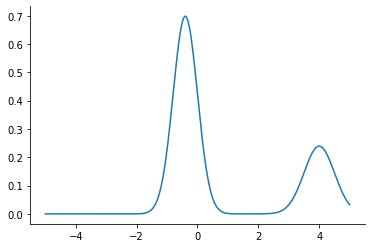

In [ ]:
plt.plot(z_values, probs)
sns.despine()

In [ ]:
tfd = tfp.distributions

def create_q(loc, scale):
    return tfd.Normal(loc=jnp.array(loc), scale=jnp.array(scale))

q_1 = create_q(3.0, 1.0)
q_2 = create_q(3.0, 4.5)

log_probs = p_s.log_prob(z_values)
prob_values_p_s = jnp.exp(jnp.asarray(log_probs))

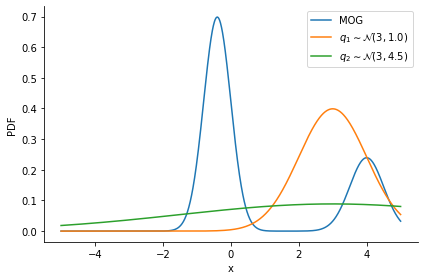

In [ ]:
z_values = jnp.linspace(-5.0, 5.0, num=1000)
z_tf = tf.convert_to_tensor(z_values)
log_probs = q_1.log_prob(z_tf)
prob_values_q_1 = jnp.exp(jnp.asarray(log_probs))
log_probs = q_2.log_prob(z_tf)
prob_values_q_2 = jnp.exp(jnp.asarray(log_probs))

plt.plot(z_values, prob_values_p_s, label=r"MOG")
plt.plot(z_values, prob_values_q_1, label=r"$q_1\sim\mathcal{N} (3, 1.0)$")
plt.plot(z_values, prob_values_q_2, label=r"$q_2\sim\mathcal{N} (3, 4.5)$")

sns.despine()
plt.legend()
plt.xlabel("x")
plt.ylabel("PDF")
plt.tight_layout()
plt.savefig(
    "dkl-different.png",
    dpi=150,
)

In [ ]:
import tensorflow_probability as tfp

def kl_via_sampling(q, p, n_samples=100000):
    # Get samples from q
    sample_set = q.sample(n_samples)
    # Use the definition of KL-divergence
    return tf.reduce_mean(q.log_prob(sample_set) - p.log_prob(sample_set))


In [ ]:
n_samples = 1000
### modify this loss function for setting the condition to be forward or reverse kl divergence
def loss(loc, scale, method):
  q = tfd.Normal(loc=loc, scale=scale)
  std_normal = tfd.Normal(loc=0.0, scale=1.0)
  if (method == "forward"):
    sample_set = p_s.sample([n_samples])
    #sample_set = loc + scale * sample_set
    return tf.reduce_mean(p_s.log_prob(sample_set) - q.log_prob(sample_set))
  else:
    sample_set = std_normal.sample([n_samples])
    sample_set = loc + scale * sample_set
    return tf.reduce_mean(q.log_prob(sample_set) - p_s.log_prob(sample_set))

In [ ]:
optimizer = tf.optimizers.Adam(learning_rate=1)

In [ ]:
tf.random.set_seed(42)

# Define the trainable parameters
loc = tf.Variable(8.0, name="loc", dtype=tf.float32, trainable=True)
scale = tf.Variable(0.1, name="scale", dtype=tf.float32, trainable=True)

In [ ]:
import tensorflow_probability as tfp
import tensorflow as tf

tf.random.set_seed(42)

# Define the trainable parameters
loc = tf.Variable(8.0, name="loc", dtype=tf.float32, trainable=True)
scale = tf.Variable(0.1, name="scale", dtype=tf.float32, trainable=True)


# Define the optimizer
opt = tf.optimizers.Adam(learning_rate=0.2)

# Train the model
loc_array = []
scale_array = []
loss_array = []
for i in range(3001):
    with tf.GradientTape() as tape:
        # Compute the loss and store its value
        loss_value = loss(loc, scale, "forward")
        loss_array.append(loss_value.numpy())

    # Compute the gradients and update the parameters
    gradients = tape.gradient(loss_value, [loc, scale])
    opt.apply_gradients(zip(gradients, [loc, scale]))

    # Store the current parameter values
    loc_array.append(loc.numpy())
    scale_array.append(scale.numpy())

    if i % 100 == 0:
        print(f"Iteration: {i}, Loss: {loss_value.numpy():0.2f}, Loc: {loc.numpy():0.2f}, Scale: {scale.numpy():0.2f}")


Iteration: 0, Loss: 2770.92, Loc: 7.80, Scale: 0.30
Iteration: 100, Loss: 7.56, Loc: 5.98, Scale: 1.40
Iteration: 200, Loss: 5.33, Loc: 5.15, Scale: 1.44
Iteration: 300, Loss: 3.77, Loc: 4.29, Scale: 1.47
Iteration: 400, Loss: 2.76, Loc: 3.51, Scale: 1.50
Iteration: 500, Loss: 1.82, Loc: 2.84, Scale: 1.52
Iteration: 600, Loss: 1.45, Loc: 2.30, Scale: 1.53
Iteration: 700, Loss: 1.33, Loc: 1.87, Scale: 1.54
Iteration: 800, Loss: 1.13, Loc: 1.56, Scale: 1.55
Iteration: 900, Loss: 1.09, Loc: 1.33, Scale: 1.56
Iteration: 1000, Loss: 1.06, Loc: 1.18, Scale: 1.56
Iteration: 1100, Loss: 1.10, Loc: 1.07, Scale: 1.57
Iteration: 1200, Loss: 1.05, Loc: 1.01, Scale: 1.58
Iteration: 1300, Loss: 1.04, Loc: 0.97, Scale: 1.59
Iteration: 1400, Loss: 1.02, Loc: 0.95, Scale: 1.59
Iteration: 1500, Loss: 1.03, Loc: 0.93, Scale: 1.60
Iteration: 1600, Loss: 1.00, Loc: 0.93, Scale: 1.61
Iteration: 1700, Loss: 1.03, Loc: 0.92, Scale: 1.62
Iteration: 1800, Loss: 1.01, Loc: 0.92, Scale: 1.63
Iteration: 1900, Loss

In [ ]:
q_s = tfd.Normal(loc=loc, scale=scale)

Text(0, 0.5, 'PDF')

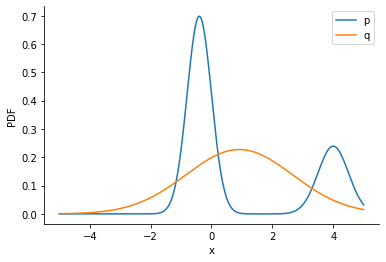

In [ ]:
prob_values_p_s = jnp.exp(jnp.asarray(p_s.log_prob(z_values)))
prob_values_q_s = jnp.exp(jnp.asarray(q_s.log_prob(z_values)))

plt.plot(z_values, prob_values_p_s, label=r"p")
plt.plot(z_values, prob_values_q_s, label=r"q")

sns.despine()
plt.legend()
plt.xlabel("x")
plt.ylabel("PDF")

In [ ]:
from matplotlib import animation

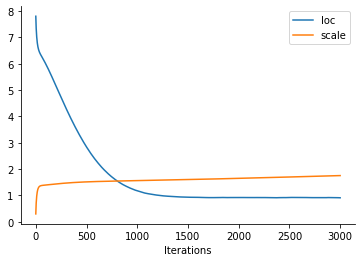

In [ ]:
prob_values_p_s = p_s.prob(z_values)

fig = plt.figure(tight_layout=True, figsize=(8, 4))
ax = fig.gca()
n_iter = 1000

def a(iteration):
    ax.clear()
    loc = loc_array[iteration]
    scale = scale_array[iteration]
    q_s = tfp.distributions.Normal(loc=loc, scale=tf.nn.softplus(scale))

    prob_values_q_s = q_s.prob(z_values)

    ax.plot(z_values, prob_values_p_s, label=r"p")
    ax.plot(z_values, prob_values_q_s, label=r"q")
    ax.set_title(f"Iteration {iteration}, Loss: {loss_array[iteration]:0.2f}")
    ax.set_ylim((-0.05, 1.05))
    ax.legend()

ani_mg = animation.FuncAnimation(fig, a, frames=n_iter)
plt.close()
plt.plot(loc_array, label="loc")
plt.plot(scale_array, label="scale")
plt.xlabel("Iterations")
sns.despine()
plt.legend()


In [ ]:
from IPython.display import HTML

In [ ]:
HTML(ani_mg.to_jshtml())

reverse kl divergence minimization

In [ ]:
tf.random.set_seed(42)

# Define the trainable parameters
loc = tf.Variable(8.0, name="loc", dtype=tf.float32, trainable=True)
scale = tf.Variable(0.1, name="scale", dtype=tf.float32, trainable=True)


# Define the optimizer
opt = tf.optimizers.Adam(learning_rate=0.2)

# Train the model
loc_array = []
scale_array = []
loss_array = []
for i in range(3001):
    with tf.GradientTape() as tape:
        # Compute the loss and store its value
        loss_value = loss(loc, scale, "reverse")
        loss_array.append(loss_value.numpy())

    # Compute the gradients and update the parameters
    gradients = tape.gradient(loss_value, [loc, scale])
    opt.apply_gradients(zip(gradients, [loc, scale]))

    # Store the current parameter values
    loc_array.append(loc.numpy())
    scale_array.append(scale.numpy())

    if i % 100 == 0:
        print(f"Iteration: {i}, Loss: {loss_value.numpy():0.2f}, Loc: {loc.numpy():0.2f}, Scale: {scale.numpy():0.2f}")

In [ ]:
q_s = tfd.Normal(loc=loc, scale=scale)

In [ ]:
prob_values_p_s = jnp.exp(jnp.asarray(p_s.log_prob(z_values)))
prob_values_q_s = jnp.exp(jnp.asarray(q_s.log_prob(z_values)))

plt.plot(z_values, prob_values_p_s, label=r"p")
plt.plot(z_values, prob_values_q_s, label=r"q")

sns.despine()
plt.legend()
plt.xlabel("x")
plt.ylabel("PDF")

In [ ]:
prob_values_p_s = p_s.prob(z_values)

fig = plt.figure(tight_layout=True, figsize=(8, 4))
ax = fig.gca()
n_iter = 1000


ani_mg = animation.FuncAnimation(fig, a, frames=n_iter)
plt.close()
plt.plot(loc_array, label="loc")
plt.plot(scale_array, label="scale")
plt.xlabel("Iterations")
sns.despine()
plt.legend()


In [ ]:
HTML(ani_mg.to_jshtml())